In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize, curve_fit

import sys
sys.path.insert(0, "../func_py/")
sys.path.insert(0, "../func_build/")
import infer_noise as infn
import data_utils as dt
import my_utils as ut

In [11]:
def read_params_across_model(sample):
    betas, fmins, ass, bss = [], [], [], []
    for model in models:
        result = dt.read_noise_result('inference/noise/'+sample+'_'+model+'.txt', model)
        betas.append(result['beta'])
        fmins.append(10**result['fmin'])
        if 'a' not in result: result['a'] = 0.0001
        if 'b' not in result: result['b'] = 1
        ass.append(result['a'])
        bss.append(result['b'])
    return betas, fmins, ass, bss


def import_downsampled_replicates(sample, N_cell_min):
    R = metadata.loc[sample].repl_count
    merged = pd.DataFrame(columns=['familiy_pairs'])
    for r in range(R):
        r_fr = dt.read_family_frame(sample+'_r'+str(r+1), True)
        f_aux = dt.downsample_frame(r_fr.groupby('familiy_pairs').agg({'pair_count':sum}), N_cell_min)
        merged = pd.merge(merged, f_aux, on='familiy_pairs', how='outer', suffixes=('', '_'+str(r+1))).fillna(0)
    count_mat_down = np.array(merged.drop('familiy_pairs', axis=1).values, dtype=int)
    return dt.build_sparse_counts(count_mat_down.T)
    

def plot_pns(ax, P_nss, n_uniq, n_counts):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r"$n = \sum_r {n}^r$", fontsize=12)
    ax.set_ylabel(r"$P({n} | {n}>0)$", fontsize=12)
    ax.scatter(n_uniq, n_counts / np.sum(n_counts), color='grey', label='data')
    for i in range(len(models)):
        ax.plot(ns, P_nss[i], label=models[i], color=colors[i], ls=style[i], lw=3)
    return ax


def plot_n_given_m_minus(ax, m_minuss, nis_list, pni_at_ns_list, nis_th, pni_at_ns_th_list):
    c_m = ['#000000', '#929591']
    ax.set_xlabel(r"${n}^r$", fontsize=12)
    ax.set_ylabel(r"$P({n}^r | {n}^{-r})$", fontsize=12)
    ax.set_yscale('log')
    ax.set_xscale('log')
    #ax.set_xlim(np.min(pni_at_ns_list), 1.2)
    aux_ns_th = np.append([0.5], nis_th[1:])
    for i, ns in enumerate(m_minuss):
        for j in range(len(models)):
            ax.plot(aux_ns_th, pni_at_ns_th_list[j][i], c=colors[j], ls=style[j], lw=3)
        lab = r"${n}^{-r} =$" + str(m_minuss[i])
        ax.scatter(nis_list[i][0], pni_at_ns_list[i][0], alpha=0.7, c=c_m[i], label=lab, s=70)
        for r in range(1,len(N_cells)):
            aux_ns = np.append([0.5], nis_list[i][r][1:])
            ax.scatter(aux_ns, pni_at_ns_list[i][r], alpha=0.8, c=c_m[i], s=70)
    ax.legend()
    return ax

In [3]:
metadata = pd.read_csv('metadata/metadata.tsv', sep='\t', index_col=0)
models = ['poisson', 'negbin', 'negbin_b']
model_labels = ['poisson', 'negbin', 'negbin b=1']
n_pars = [2, 3, 4]
colors = ['indigo', 'red', 'orange']
style = ['-', '--', ':']

In [4]:
#sample = 'pat2_t1_mc'
sample = 'pat2_t3_pc'
betas, fmins, ass, bss = read_params_across_model(sample)

n_uniq_repl, n_counts_repl = dt.import_sample_counts(sample, metadata.loc[sample].repl_count)
aux = pd.DataFrame([n_uniq_repl.sum(axis=1), n_counts_repl]).T.groupby(0).agg(sum)
n_uniq, n_counts = aux.index.values, aux[1].values
N_cells = np.sum(n_uniq_repl * n_counts_repl[:,np.newaxis], axis=0)

down_fr = import_downsampled_replicates(sample, min(N_cells))

In [7]:
ns = np.arange(1, 35)
P_nss = []
for i in range(len(models)):
    P_nss.append(infn.compute_pn(ns, betas[i], fmins[i], ass[i], bss[i], N_cells))
    
# Observed and predicted statistics of single-replicate abundance given abundance other replicates
m_minuss = [1, 4]
counts_th = np.arange(8)
pni_at_ns_th_lists = []
nis_list, pni_at_ns_list, pni_at_ns_th_list = [], [], [[] for _ in range(len(models))]
for m_minus in m_minuss:
    nis_aux, pni_aux = [], []
    for r in range(len(N_cells)):
        nis, pni_at_ns = ut.get_pn_at_m_minus(r+1, m_minus, len(N_cells), down_fr)
        nis_aux.append(nis)
        pni_aux.append(pni_at_ns)
    nis_list.append(nis_aux)
    pni_at_ns_list.append(pni_aux)
    
    for i in range(len(models)):
        pni_at_ns_th_list[i].append(infn.compute_pn_at_m_minus(counts_th, m_minus, len(N_cells), 
                                                               betas[i], fmins[i], ass[i], bss[i], min(N_cells)))

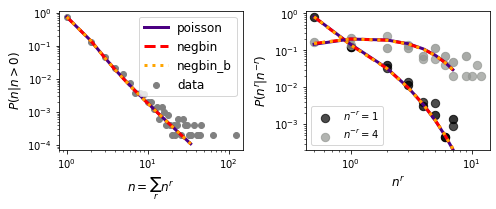

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
plot_pns(ax1, P_nss, n_uniq, n_counts)
#ax1.set_ylim(1.2 * 10**(-4), 1.2)
ax1.set_xlim(0.8, 150)
ax1.legend(fontsize=12)
plot_n_given_m_minus(ax2, m_minuss, nis_list, pni_at_ns_list, counts_th, pni_at_ns_th_list)
#ax2.set_xlim(-0.3, 12)
ax2.set_ylim(2 * 10**(-4), 1.2)
#ax2.legend(fontsize=12)
plt.tight_layout()

plt.savefig('plots/noise/marginals_'+sample+'.svg')